In [13]:
import glob

import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import imutils
import random
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input,Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, ZeroPadding2D,MaxPool2D,SeparableConv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image

from sklearn.metrics import confusion_matrix, classification_report


In [2]:
PATH = './chest_xray/'

TRAIN_DATA_DIR = PATH + 'train'
TEST_DATA_DIR = PATH + 'test'
VAL_DATA_DIR = PATH + 'val'


TRAIN_DATA_NORMAL_FILE = PATH + 'train/NORMAL/'
TRAIN_DATA_PNEUMONIA_FILE = PATH + 'train/PNEUMONIA/'
VAL_DATA_NORMAL_FILE = PATH + 'val/NORMAL/'
VAL_DATA_PNEUMONIA_FILE = PATH + 'val/PNEUMONIA/'
TEST_DATA_NORMAL_FILE = PATH + 'test/NORMAL/'
TEST_DATA_PNEUMONIA_FILE = PATH + 'test/PNEUMONIA/'

IMAGE_SIZE = (256,256)
BATCH_SIZE = 32
EPOCHS = 10


train_data_normal = glob.glob(TRAIN_DATA_NORMAL_FILE + '*jpeg')
train_data_pneumonia = glob.glob(TRAIN_DATA_PNEUMONIA_FILE + '*jpeg')
val_data_normal = glob.glob(VAL_DATA_NORMAL_FILE + '*jpeg')
val_data_pneumonia = glob.glob(VAL_DATA_PNEUMONIA_FILE + '*jpeg')
test_data_normal = glob.glob(TEST_DATA_NORMAL_FILE + '*jpeg')
test_data_pneumonia = glob.glob(TEST_DATA_PNEUMONIA_FILE + '*jpeg')

In [3]:
train_data_generator = ImageDataGenerator(rescale = 1/255)

test_data_generator = ImageDataGenerator(rescale = 1/255)

In [4]:

train_generator = train_data_generator.flow_from_directory(
        TRAIN_DATA_DIR,
        target_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        class_mode = 'binary')

test_generator = test_data_generator.flow_from_directory(
        VAL_DATA_DIR,
        target_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        class_mode = 'binary')

Found 6788 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


In [17]:
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(8, (3,3), padding='same', activation='relu', input_shape=(256,256,3)),
    tf.keras.layers.MaxPool2D(3,3),
    
    # CNN Layer 1
    tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(3,3),
    # CNN Layer 2
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # CNN Layer 3
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # CNN Layer 4
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Layer 6
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 256, 256, 8)       224       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 85, 85, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 85, 85, 16)        1168      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)       

In [6]:
from tensorflow.keras.optimizers import RMSprop
model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.0001),metrics=['accuracy'])

In [7]:

checkpoint = ModelCheckpoint('detect_pneumonia.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')

history=model.fit(train_generator, 
                  epochs = EPOCHS, 
                  validation_data = test_generator, 
                  callbacks=[checkpoint,lr_reduce])

Epoch 1/10
213/213 [==============================] - 127s 594ms/step - loss: 0.5939 - accuracy: 0.7203 - val_loss: 0.3108 - val_accuracy: 0.8882

Epoch 00001: val_loss improved from inf to 0.31075, saving model to detect_pneumonia.h5
Epoch 2/10
213/213 [==============================] - 122s 574ms/step - loss: 0.2901 - accuracy: 0.8925 - val_loss: 0.1925 - val_accuracy: 0.9386

Epoch 00002: val_loss improved from 0.31075 to 0.19249, saving model to detect_pneumonia.h5
Epoch 3/10
213/213 [==============================] - 135s 633ms/step - loss: 0.2253 - accuracy: 0.9119 - val_loss: 0.2078 - val_accuracy: 0.9104

Epoch 00003: val_loss did not improve from 0.19249

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
Epoch 4/10
213/213 [==============================] - 140s 657ms/step - loss: 0.1753 - accuracy: 0.9315 - val_loss: 0.1388 - val_accuracy: 0.9480

Epoch 00004: val_loss improved from 0.19249 to 0.13879, saving model to detect_pneumonia.h5
Epoch 5

<Figure size 432x288 with 0 Axes>

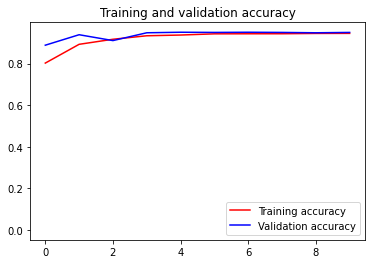

<Figure size 432x288 with 0 Axes>

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.plot(range(0, 1))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


In [11]:

test_generator = test_data_generator.flow_from_directory(
        TEST_DATA_DIR,
        target_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        class_mode = 'binary')

test_generator.class_indices
result = model.evaluate_generator(test_generator)
print("Accuracy: {}".format(result[1]))

Found 586 images belonging to 2 classes.
Accuracy: 0.935153603553772
